In [1]:
%matplotlib inline

In [113]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [103]:
import topaz.mrc as mrc
from topaz.utils.data.loader import load_image

## Load the training data

In [4]:
with open('stack_pos.mrcs', 'rb') as f:
    content = f.read()
    stack_pos,_,_ = mrc.parse(content)
stack_pos.shape

(10000, 101, 101)

In [5]:
with open('stack_neg.mrcs', 'rb') as f:
    content = f.read()
    stack_neg,_,_ = mrc.parse(content)
stack_neg.shape

(90000, 101, 101)

In [6]:
## concatenate the features (images) into a single array and also make the binary labels
x = np.concatenate([stack_pos, stack_neg], axis=0)
y = np.zeros(len(x))
y[:len(stack_pos)] = 1 # we label positives with 1 and negatives with 0
x.shape, y.shape

((100000, 101, 101), (100000,))

In [57]:
y.sum()

10000.0

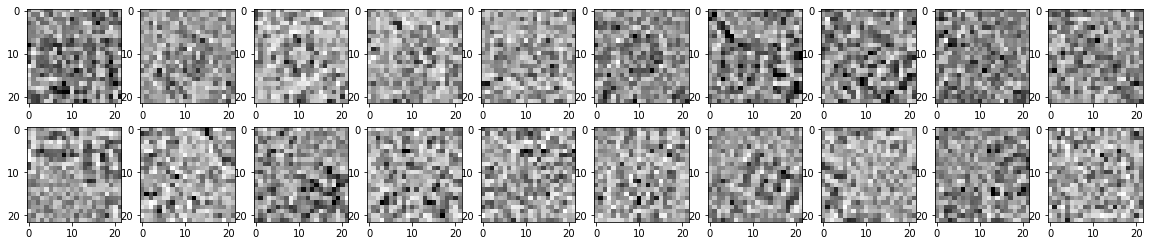

In [11]:
## take a quick look at a few positive images (particles) and a few negative images (background regions)
_,axs = plt.subplots(2,10,figsize=(20,4))
for i in range(10):
    # there is a lot of extra space around the particles in these images
    # so we'll crop to 21x21
    axs[0,i].imshow(stack_pos[i,40:62,40:62], cmap='Greys_r', vmin=-3, vmax=3)
    axs[1,i].imshow(stack_neg[i,40:62,40:62], cmap='Greys_r', vmin=-3, vmax=3)
    
# we can see that because our negatives are randomly sampled from regions not annotated as containing particles
# and not all particles are annotated in the particle stack for EMPIAR-10025, we have some negative images that
# containing particles. fortunately, there aren't too many of these and they aren't well centered on the particles,
# so our classifier training will work anyway

# if we had fewer positives this would be a problem...

In [12]:
## Before we set up a neural network and get training, we split holdout some of the images as a validation set.
## The validation set allows us to assess the model performance on unseen data to ensure that it isn't overfitting. 

In [13]:
random = np.random.RandomState(42)
order = random.permutation(len(x))
n = int(0.1*len(x))
x_val = x[order[:n]]
y_val = y[order[:n]]
x_train = x[order[n:]]
y_train = y[order[n:]]

In [58]:
y_val.sum(), y_train.sum()

(1023.0, 8977.0)

# Train a fully connected neural network classifier

In [62]:
# now, we set up the classifier architecture
# lets try a fully-connected neural network with window size of 31 pixels first
model = nn.Sequential(
    nn.Linear(31*31, 250),
    nn.ReLU(inplace=True),
    nn.Linear(250, 250),
    nn.ReLU(inplace=True),
    nn.Linear(250, 1)
)

In [63]:
use_cuda = True
torch.cuda.set_device(1)
if use_cuda:
    model.cuda() # move the model to the GPU

In [64]:
# crop the images to fit the 31 pixel window size and create minibatch iterators
# and the optimizer
x_val_crop = x_val[:,35:-35,35:-35].copy()
x_train_crop = x_train[:,35:-35,35:-35].copy()

x_train_crop = torch.from_numpy(x_train_crop)
y_train_torch = torch.from_numpy(y_train).float()
x_val_crop = torch.from_numpy(x_val_crop)
y_val_torch = torch.from_numpy(y_val).float()

dataset_train = torch.utils.data.TensorDataset(x_train_crop, y_train_torch)
dataset_val = torch.utils.data.TensorDataset(x_val_crop, y_val_torch)

# we'll use stochastic gradient descent with momentum. see https://pytorch.org/docs/stable/optim.html
# for SGD variants provided by pytorch
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

batch_size = 256
train_iterator = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_iterator = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

In [65]:
# lets train the model for 20 epochs measuring performance on the validation set after each one
num_epochs = 20

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(1, num_epochs+1):
    model.train() # puts the model in "training" mode. not relevant here but important for certain layers
    
    # for tracking performance over the epoch
    n = 0
    loss_accum = 0
    acc_accum = 0
    
    for x_batch, y_batch in train_iterator:
        if use_cuda:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            
        logits = model(x_batch.view(-1, 31*31)) # get prediction for each image in the minibatch
        logits = logits.squeeze() # remove last dimension of size 1
        
        # calculate the loss for the minibatch
        # here we use cross entropy loss
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)
        
        # backpropogating the gradient through the network
        loss.backward() # the core of all deep learning frameworks is automatic differentiation
        
        # update the parameters by taking a gradient step
        optim.step()
        optim.zero_grad() # zero out the stored gradients
        
        # track performance metrics over the epoch
        # this is the online mean algorithm
        b = x_batch.size(0)
        n += b
        
        delta = loss.item() - loss_accum # .item() is important to detach the compute graph!
        loss_accum += b*delta/n
        
        correct = torch.sum(((logits > 0).float() == y_batch).float()).item()
        delta = correct - b*acc_accum
        acc_accum += delta/n
        
    # training set metrics for this epoch
    train_loss.append(loss_accum)
    train_accuracy.append(acc_accum)
    print(epoch, 'train', loss_accum, acc_accum)
    
    # now, evaluate the performance on the validation set
    model.eval()
    
    n = 0
    loss_accum = 0
    acc_accum = 0
    
    with torch.no_grad(): # disables storing the compute graph for backpropogation
        for x_batch, y_batch in val_iterator:
            if use_cuda:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            logits = model(x_batch.view(-1, 31*31)).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, y_batch).item()
            correct = torch.sum(((logits > 0).float() == y_batch).float()).item()

            b = x_batch.size(0)
            n += b

            delta = loss - loss_accum
            loss_accum += b*delta/n

            delta = correct - b*acc_accum
            acc_accum += delta/n
        
    # training set metrics for this epoch
    val_loss.append(loss_accum)
    val_accuracy.append(acc_accum)
    print(epoch, 'val', loss_accum, acc_accum)
        

1 train 0.2264735014253193 0.9135777777777773
1 val 0.142166464138031 0.9427000000000001
2 train 0.1102421308517456 0.9565333333333335
2 val 0.11087335611581804 0.9570000000000001
3 train 0.06855167000889775 0.9743777777777775
3 val 0.09651801324486732 0.9629000000000001
4 train 0.04481058418982558 0.984088888888889
4 val 0.09800773618221281 0.9647999999999999
5 train 0.02856981759005124 0.9913111111111117
5 val 0.10851549269258975 0.964
6 train 0.01664263501034842 0.9960777777777778
6 val 0.115761655806005 0.9665000000000001
7 train 0.008932056849532655 0.9987333333333327
7 val 0.12224819180667405 0.9662000000000002
8 train 0.00490475327057971 0.9995555555555555
8 val 0.13264932517707348 0.9656
9 train 0.003004388919845223 0.9998111111111113
9 val 0.13617478566169738 0.9660000000000003
10 train 0.0020218591347543726 0.9998777777777774
10 val 0.14268088200613863 0.9659000000000001
11 train 0.00141791173549783 0.9999555555555546
11 val 0.14677347744703292 0.9666000000000001
12 train 0.0

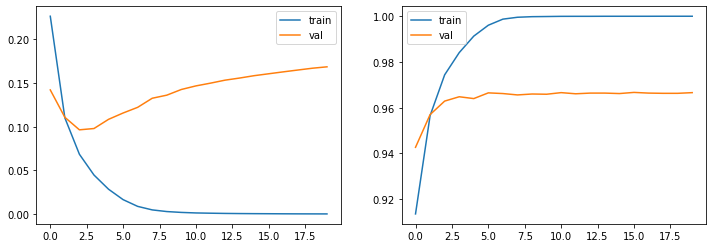

In [66]:
# plot the training results
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='val')
axs[0].legend(loc='best')
axs[1].plot(train_accuracy, label='train')
axs[1].plot(val_accuracy, label='val')
axs[1].legend(loc='best')

# Train a CNN classifier

In [83]:
# now lets try a convolutional neural network with the same window size
model = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, 5, dilation=2),
    nn.MaxPool2d(3, stride=1, dilation=2, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, 5, dilation=4),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 1, 1)
)

In [84]:
use_cuda = True
torch.cuda.set_device(1)
if use_cuda:
    model.cuda() # move the model to the GPU

In [85]:
# crop the images to fit the 31 pixel window size and create minibatch iterators
# and the optimizer
x_val_crop = x_val[:,35:-35,35:-35].copy()
x_train_crop = x_train[:,35:-35,35:-35].copy()

x_train_crop = torch.from_numpy(x_train_crop)
y_train_torch = torch.from_numpy(y_train).float()
x_val_crop = torch.from_numpy(x_val_crop)
y_val_torch = torch.from_numpy(y_val).float()

dataset_train = torch.utils.data.TensorDataset(x_train_crop, y_train_torch)
dataset_val = torch.utils.data.TensorDataset(x_val_crop, y_val_torch)

# we'll use stochastic gradient descent with momentum. see https://pytorch.org/docs/stable/optim.html
# for SGD variants provided by pytorch
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

batch_size = 256
train_iterator = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_iterator = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

In [86]:
# lets train the model for 20 epochs measuring performance on the validation set after each one
num_epochs = 20

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(1, num_epochs+1):
    model.train() # puts the model in "training" mode. not relevant here but important for certain layers
    
    # for tracking performance over the epoch
    n = 0
    loss_accum = 0
    acc_accum = 0
    
    for x_batch, y_batch in train_iterator:
        if use_cuda:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            
        logits = model(x_batch.unsqueeze(1)) # get prediction for each image in the minibatch
        logits = logits.squeeze() # remove last dimension of size 1
        
        # calculate the loss for the minibatch
        # here we use cross entropy loss
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)
        
        # backpropogating the gradient through the network
        loss.backward() # the core of all deep learning frameworks is automatic differentiation
        
        # update the parameters by taking a gradient step
        optim.step()
        optim.zero_grad() # zero out the stored gradients
        
        # track performance metrics over the epoch
        # this is the online mean algorithm
        b = x_batch.size(0)
        n += b
        
        delta = loss.item() - loss_accum # .item() is important to detach the compute graph!
        loss_accum += b*delta/n
        
        correct = torch.sum(((logits > 0).float() == y_batch).float()).item()
        delta = correct - b*acc_accum
        acc_accum += delta/n
        
    # training set metrics for this epoch
    train_loss.append(loss_accum)
    train_accuracy.append(acc_accum)
    print(epoch, 'train', loss_accum, acc_accum)
    
    # now, evaluate the performance on the validation set
    model.eval()
    
    n = 0
    loss_accum = 0
    acc_accum = 0
    
    with torch.no_grad(): # disables storing the compute graph for backpropogation
        for x_batch, y_batch in val_iterator:
            if use_cuda:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            logits = model(x_batch.unsqueeze(1)).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, y_batch).item()
            correct = torch.sum(((logits > 0).float() == y_batch).float()).item()

            b = x_batch.size(0)
            n += b

            delta = loss - loss_accum
            loss_accum += b*delta/n

            delta = correct - b*acc_accum
            acc_accum += delta/n
        
    # training set metrics for this epoch
    val_loss.append(loss_accum)
    val_accuracy.append(acc_accum)
    print(epoch, 'val', loss_accum, acc_accum)
        

1 train 0.22993093703455386 0.9174555555555555
1 val 0.12148990259170533 0.9511000000000002
2 train 0.09952788587146334 0.9606777777777783
2 val 0.10254969224929807 0.9595
3 train 0.08064178485472996 0.9679222222222215
3 val 0.10114864832162858 0.9604999999999999
4 train 0.0722982879996299 0.9719555555555558
4 val 0.08455468239188195 0.9684
5 train 0.0654577064527406 0.9748222222222225
5 val 0.079795731317997 0.9712999999999998
6 train 0.059188142679135004 0.9774333333333338
6 val 0.08076329736709593 0.9707999999999997
7 train 0.05376067433158558 0.9795222222222221
7 val 0.0797236201763153 0.9693999999999999
8 train 0.04956179041465124 0.9812111111111113
8 val 0.07679485389590261 0.9709999999999999
9 train 0.04672466257015866 0.9829333333333333
9 val 0.07781337809264662 0.9708
10 train 0.04238536036147012 0.984155555555556
10 val 0.0970346799850464 0.9693
11 train 0.038925769099262014 0.9857999999999998
11 val 0.09370592993199822 0.9661000000000001
12 train 0.035791037475731674 0.98686

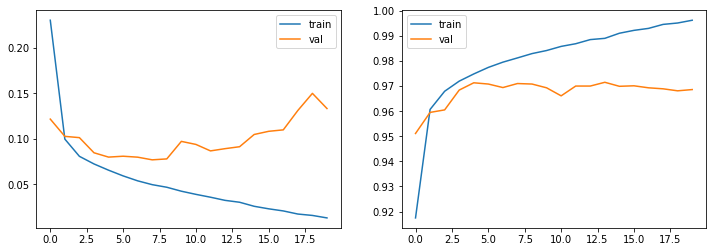

In [87]:
# plot the training results
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='val')
axs[0].legend(loc='best')
axs[1].plot(train_accuracy, label='train')
axs[1].plot(val_accuracy, label='val')
axs[1].legend(loc='best')

## Add dropout regularization

In [98]:
# we started to overfit
# let's try adding some dropout regularization to the model
model = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(32, 32, 5, dilation=2),
    nn.MaxPool2d(3, stride=1, dilation=2, padding=1),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(32, 32, 5, dilation=4),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(32, 1, 1)
)

In [99]:
use_cuda = True
torch.cuda.set_device(1)
if use_cuda:
    model.cuda() # move the model to the GPU

In [100]:
# crop the images to fit the 31 pixel window size and create minibatch iterators
# and the optimizer
x_val_crop = x_val[:,35:-35,35:-35].copy()
x_train_crop = x_train[:,35:-35,35:-35].copy()

x_train_crop = torch.from_numpy(x_train_crop)
y_train_torch = torch.from_numpy(y_train).float()
x_val_crop = torch.from_numpy(x_val_crop)
y_val_torch = torch.from_numpy(y_val).float()

dataset_train = torch.utils.data.TensorDataset(x_train_crop, y_train_torch)
dataset_val = torch.utils.data.TensorDataset(x_val_crop, y_val_torch)

# we'll use stochastic gradient descent with momentum. see https://pytorch.org/docs/stable/optim.html
# for SGD variants provided by pytorch
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

batch_size = 256
train_iterator = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_iterator = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

In [101]:
# lets train the model for 20 epochs measuring performance on the validation set after each one
num_epochs = 20

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(1, num_epochs+1):
    model.train() # puts the model in "training" mode. not relevant here but important for certain layers
    
    # for tracking performance over the epoch
    n = 0
    loss_accum = 0
    acc_accum = 0
    
    for x_batch, y_batch in train_iterator:
        if use_cuda:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            
        logits = model(x_batch.unsqueeze(1)) # get prediction for each image in the minibatch
        logits = logits.squeeze() # remove last dimension of size 1
        
        # calculate the loss for the minibatch
        # here we use cross entropy loss
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)
        
        # backpropogating the gradient through the network
        loss.backward() # the core of all deep learning frameworks is automatic differentiation
        
        # update the parameters by taking a gradient step
        optim.step()
        optim.zero_grad() # zero out the stored gradients
        
        # track performance metrics over the epoch
        # this is the online mean algorithm
        b = x_batch.size(0)
        n += b
        
        delta = loss.item() - loss_accum # .item() is important to detach the compute graph!
        loss_accum += b*delta/n
        
        correct = torch.sum(((logits > 0).float() == y_batch).float()).item()
        delta = correct - b*acc_accum
        acc_accum += delta/n
        
    # training set metrics for this epoch
    train_loss.append(loss_accum)
    train_accuracy.append(acc_accum)
    print(epoch, 'train', loss_accum, acc_accum)
    
    # now, evaluate the performance on the validation set
    model.eval()
    
    n = 0
    loss_accum = 0
    acc_accum = 0
    
    with torch.no_grad(): # disables storing the compute graph for backpropogation
        for x_batch, y_batch in val_iterator:
            if use_cuda:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            logits = model(x_batch.unsqueeze(1)).squeeze()
            loss = F.binary_cross_entropy_with_logits(logits, y_batch).item()
            correct = torch.sum(((logits > 0).float() == y_batch).float()).item()

            b = x_batch.size(0)
            n += b

            delta = loss - loss_accum
            loss_accum += b*delta/n

            delta = correct - b*acc_accum
            acc_accum += delta/n
        
    # training set metrics for this epoch
    val_loss.append(loss_accum)
    val_accuracy.append(acc_accum)
    print(epoch, 'val', loss_accum, acc_accum)
        

1 train 0.2675305913739732 0.9008777777777772
1 val 0.14472245454788205 0.9406999999999998
2 train 0.1443357766615019 0.9415111111111112
2 val 0.1472406992912292 0.9430000000000001
3 train 0.11861180035273235 0.9525666666666667
3 val 0.11018970394134522 0.9574999999999999
4 train 0.11052669938140457 0.9569444444444445
4 val 0.10018578382730484 0.9632000000000001
5 train 0.09952392353084356 0.961077777777778
5 val 0.09802240307927135 0.9618
6 train 0.09670435946517526 0.9635777777777774
6 val 0.09248104048967362 0.9640999999999998
7 train 0.09091689044766958 0.9653111111111109
7 val 0.08234868433475497 0.9673999999999999
8 train 0.08745501771503025 0.9664888888888887
8 val 0.07981321516633033 0.9679999999999995
9 train 0.0868016297048993 0.9668555555555557
9 val 0.08002651400566103 0.9691
10 train 0.08510285227166278 0.9675999999999996
10 val 0.0834220711350441 0.9693999999999998
11 train 0.08238919518656196 0.9692333333333335
11 val 0.07648838152885437 0.9704000000000002
12 train 0.081

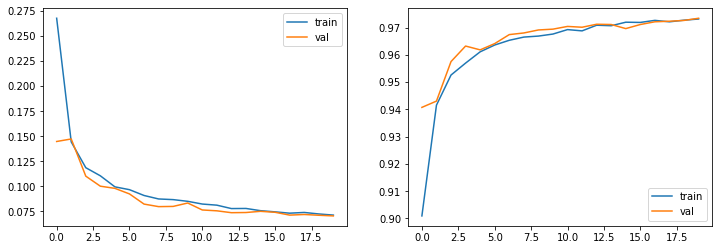

In [102]:
# plot the training results
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='val')
axs[0].legend(loc='best')
axs[1].plot(train_accuracy, label='train')
axs[1].plot(val_accuracy, label='val')
axs[1].legend(loc='best')

## Apply the trained classifier to whole micrographs

In [106]:
## now let's see what predictions with this model look like on whole micrographs
path = 'data/14sep05c_c_00003gr_00014sq_00002hl_00005es_c.tiff'
im = np.array(load_image(path), copy=False)

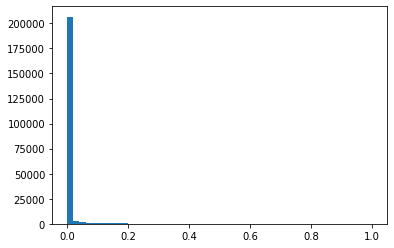

In [107]:
# apply the classifier to the micrograph
im_torch = torch.from_numpy(im).float().unsqueeze(0).unsqueeze(0)
if use_cuda:
    im_torch = im_torch.cuda()
im_torch = F.pad(im_torch, (15,15,15,15))
with torch.no_grad():
    logits = model(im_torch).squeeze().cpu().numpy()
p = 1/(1 + np.exp(-logits)) # convert the log-likelihood ratios to predicted probabilities

# plot the histogram of the predicted probabilities
_ = plt.hist(p.ravel(), bins=50)

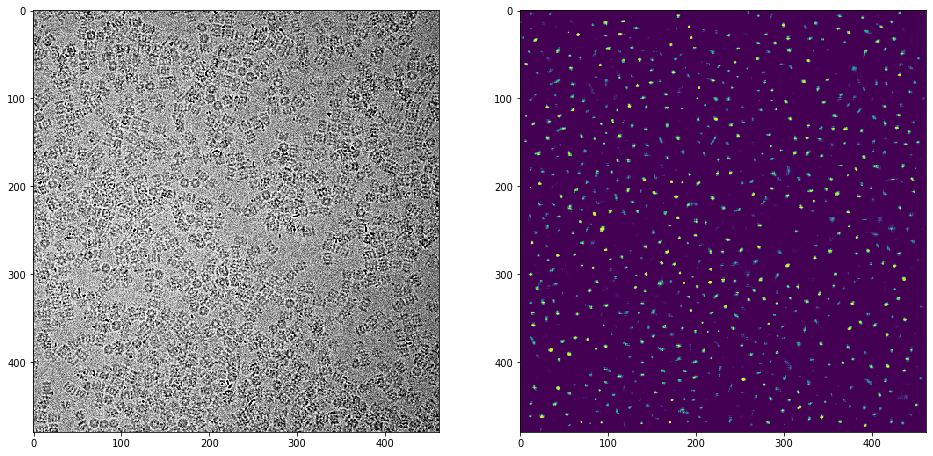

In [109]:
_,axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].imshow(im, cmap='Greys_r', vmin=-3, vmax=3)
axs[1].imshow(p)

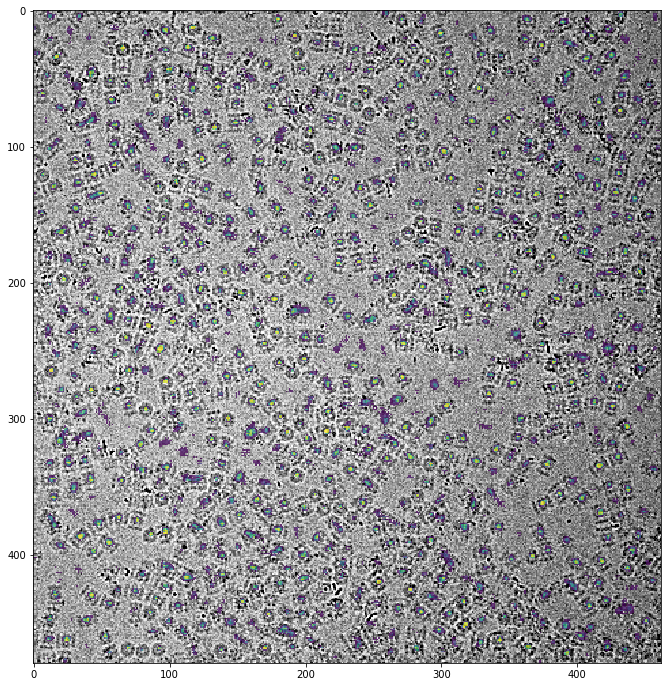

In [111]:
# overlay the predictions - they look pretty good!
p_mask = np.ma.masked_array(p, p < 0.01)
_,ax = plt.subplots(figsize=(12,12))
ax.imshow(im, cmap='Greys_r', vmin=-3, vmax=3)
ax.imshow(p_mask, alpha=0.75)

In [112]:
from topaz.algorithms import non_maximum_suppression
# use the non-maximum suppression algorithm to get coordinates of particles with radius 7
# by taking predicted probabilities >= 0.5

r = 7
scores, coords = non_maximum_suppression(p, r, threshold=0.5)

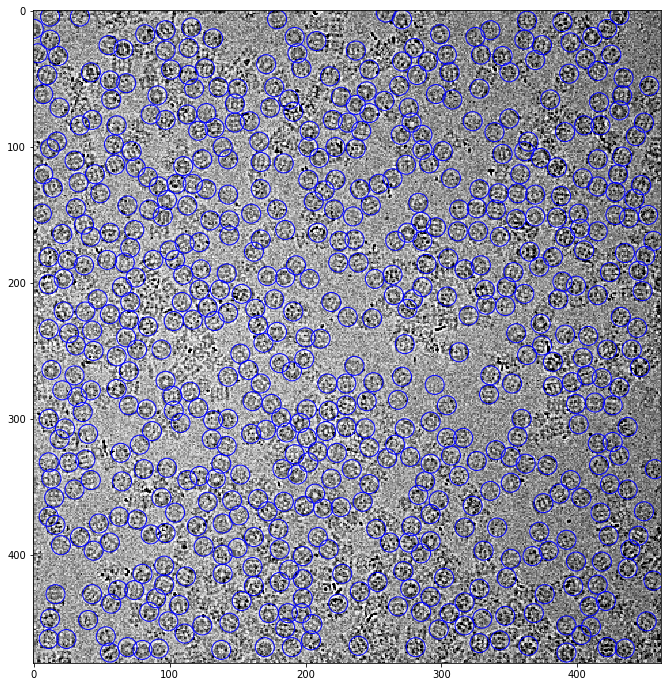

In [116]:
# visualize the micrograph with the predictions overlayed
_,ax = plt.subplots(figsize=(12,12))
ax.imshow(im, cmap='Greys_r', vmin=-3, vmax=3)
for x_coord,y_coord in coords:
    c = Circle((x_coord, y_coord), r, color='b', fill=False)
    ax.add_artist(c)